# Quantum Fourier Transform

In this tutorial, we introduce the quantum fourier transform (QFT), derive the circuit, and implement it using Qiskit. We show how to run QFT on a simulator and a five qubit device.

## Contents
1. [Introduction](#introduction)
2. [Intuition](#intuition)     
    2.1 [Counting in the Fourier Basis](#counting-fourier)    
3. [Example 1: 1-qubit QFT](#example1)
4. [The Quantum Fourier transform](#qfteqn)
5. [The Circuit that Implements the QFT](#circuit)
6. [Example 2: 3-qubit QFT](#example2)
7. [Some Notes About the Form of the QFT Circuit](#formnote)
8. [Qiskit Implementation](#implementation)     
    8.1 [Example on 3 Qubits](#threeqft)    
    8.2 [General QFT Function](#generalqft)    
    8.3 [Running QFT on a Real Quantum Device](#implementationdev)    
9. [Problems](#problems)
10. [References](#references)

## 1. Introduction <a id='introduction'></a>

The Fourier transform occurs in many different versions throughout classical computing, in areas ranging from signal processing to data compression to complexity theory. The quantum Fourier transform (QFT) is the quantum implementation of the discrete Fourier transform over the amplitudes of a wavefunction. It is part of many quantum algorithms, most notably Shor's factoring algorithm and quantum phase estimation. 

The discrete Fourier transform acts on a vector $(x_0, ..., x_{N-1})$ and maps it to the vector $(y_0, ..., y_{N-1})$ according to the formula


$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$


where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$.

Similarly, the quantum Fourier transform acts on a quantum state $\vert X\rangle = \sum_{j=0}^{N-1} x_j \vert j \rangle$ and maps it to the quantum state $\vert Y\rangle = \sum_{k=0}^{N-1} y_k \vert k \rangle$ according to the formula


$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$


with $\omega_N^{jk}$ defined as above. Note that only the amplitudes of the state were affected by this transformation.

This can also be expressed as the map:


$$\vert j \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\omega_N^{jk} \vert k \rangle$$



Or the unitary matrix:


$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} \omega_N^{jk} \vert k \rangle \langle j \vert$$



## 2. Intuition <a id="intuition"></a>

The quantum Fourier transform (QFT) transforms between two bases, the computational (Z) basis, and the Fourier basis. The H-gate is the single-qubit QFT, and it transforms between the Z-basis states $|0\rangle$ and $|1\rangle$ to the X-basis states $|{+}\rangle$ and $|{-}\rangle$. In the same way, all multi-qubit states in the computational basis have corresponding states in the Fourier basis. The QFT is simply the function that transforms between these bases.

$$
|\text{State in Computational Basis}\rangle \quad \xrightarrow[]{\text{QFT}} \quad |\text{State in Fourier Basis}\rangle
$$

$$
\text{QFT}|x\rangle = |\widetilde{x}\rangle
$$

(We often note states in the Fourier basis using the tilde (~)).

### 2.1 Counting in the Fourier basis: <a id="counting-fourier"></a>

In the computational basis, we store numbers in binary using the states $|0\rangle$ and $|1\rangle$:

![zbasiscounting](images/zbasis-counting.gif)

Note the frequency with which the different qubits change; the leftmost qubit flips with every increment in the number, the next with every 2 increments, the third with every 4 increments, and so on. In the Fourier basis, we store numbers using different rotations around the Z-axis:

![fbasiscounting](images/fourierbasis-counting.gif)

The number we want to store dictates the angle at which each qubit is rotated around the Z-axis. In the state $|\widetilde{0}\rangle$, all qubits are in the state $|{+}\rangle$. As seen in the example above, to encode the state $|\widetilde{5}\rangle$ on 4 qubits, we rotated the leftmost qubit by $\tfrac{5}{2^n} = \tfrac{5}{16}$ full turns ($\tfrac{5}{16}\times 2\pi$ radians). The next qubit is turned double this ($\tfrac{10}{16}\times 2\pi$ radians, or $10/16$ full turns), this angle is then doubled for the qubit after, and so on. 

Again, note the frequency with which each qubit changes. The leftmost qubit (`qubit 0`) in this case has the lowest frequency, and the rightmost the highest. 


## 3. Example 1: 1-qubit QFT <a id='example1'></a>

Consider how the QFT operator as defined above acts on a single qubit state $\vert\psi\rangle = \alpha \vert 0 \rangle + \beta \vert 1 \rangle$. In this case, $x_0 = \alpha$, $x_1 = \beta$, and $N = 2$. Then,



$$y_0 = \frac{1}{\sqrt{2}}\left(    \alpha \exp\left(2\pi i\frac{0\times0}{2}\right) + \beta \exp\left(2\pi i\frac{1\times0}{2}\right)      \right) = \frac{1}{\sqrt{2}}\left(\alpha + \beta\right)$$



and



$$y_1 = \frac{1}{\sqrt{2}}\left(    \alpha \exp\left(2\pi i\frac{0\times1}{2}\right) + \beta \exp\left(2\pi i\frac{1\times1}{2}\right)      \right) = \frac{1}{\sqrt{2}}\left(\alpha - \beta\right)$$



such that the final result is the state 



$$U_{QFT}\vert\psi\rangle = \frac{1}{\sqrt{2}}(\alpha + \beta) \vert 0 \rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)  \vert 1 \rangle$$



This operation is exactly the result of applying the Hadamard operator ($H$) on the qubit:



$$H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$$



If we apply the $H$ operator to the state $\vert\psi\rangle = \alpha \vert 0 \rangle + \beta \vert 1 \rangle$, we obtain the new state:

$$\frac{1}{\sqrt{2}}(\alpha + \beta) \vert 0 \rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)  \vert 1 \rangle 
\equiv \tilde{\alpha}\vert 0 \rangle + \tilde{\beta}\vert 1 \rangle$$

Notice how the Hadamard gate performs the discrete Fourier transform for $N = 2$ on the amplitudes of the state. 

## 4. The Quantum Fourier transform<a id="qfteqn"></a>

So what does the quantum Fourier transform look like for larger $N$? Let's derive a transformation for $N=2^n$, $QFT_N$ acting on the state $\vert x \rangle = \vert x_1\ldots x_n \rangle$ where $x_1$ is the most significant bit. This maths is here for those that find it useful, if you struggle with it then don’t worry; as long as you understand the intuition in section 2 then you can continue straight to the next section.

$$
\begin{aligned}
QFT_N\vert x \rangle & = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle 
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i xy / 2^n} \vert y \rangle ~\text{since}\: \omega_N^{xy} = e^{2\pi i \frac{xy}{N}} \:\text{and}\: N = 2^n 
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i \left(\sum_{k=1}^n y_k/2^k\right) x} \vert y_1 \ldots y_n \rangle \:\text{rewriting in fractional binary notation}\: y = y_1\ldots y_n, y/2^n = \sum_{k=1}^n y_k/2^k 
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=1}^n e^{2 \pi i x y_k/2^k } \vert y_1 \ldots y_n \rangle \:\text{after expanding the exponential of a sum to a product of exponentials} 
\\
& = \frac{1}{\sqrt{N}} \bigotimes_{k=1}^n  \left(\vert0\rangle + e^{2 \pi i x /2^k } \vert1\rangle \right) \:\text{after rearranging the sum and products, and expanding} 
\sum_{y=0}^{N-1} = \sum_{y_1=0}^{1}\sum_{y_2=0}^{1}\ldots\sum_{y_n=0}^{1} 
\\
& = \frac{1}{\sqrt{N}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right) 
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right) 
\end{aligned}
$$

This is a mathematical description of the animation we saw in the intuition section:

![fbasiscounting](images/fourierbasis-counting.gif)

## 5. The Circuit that Implements the QFT <a name="circuit"></a>

The circuit that implements QFT makes use of two gates. The first one is a single-qubit Hadamard gate, $H$, that you already know. From the discussion in [Example 1](#example1) above, you have already seen that the action of $H$ on the single-qubit state $\vert x_k\rangle$ is



$$H\vert x_k \rangle = \frac{1}{\sqrt{2}}\left(\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_k\right)\vert1\rangle\right)$$



The second is a two-qubit controlled rotation $CROT_k$ given in block-diagonal form as 

$$CROT_k = \left[\begin{matrix}
I&0\\
0&UROT_k\\
\end{matrix}\right]$$

where 

$$UROT_k = \left[\begin{matrix}
1&0\\
0&\exp\left(\frac{2\pi i}{2^k}\right)\\
\end{matrix}\right]$$

The action of $CROT_k$ on a two-qubit state $\vert x_l x_j\rangle$ where the first qubit is the control and the second is the target is given by



$$CROT_k\vert 0x_j\rangle = \vert 0x_j\rangle$$


and


$$CROT_k\vert 1x_j\rangle = \exp\left( \frac{2\pi i}{2^k}x_j \right)\vert 1x_j\rangle$$



Given these two gates, a circuit that implements [an n-qubit QFT](#qfteqn) is shown below.

![image1](images/qft.png)

The circuit operates as follows. We start with an n-qubit input state $\vert x_1x_2\ldots x_n\rangle$.

<ol>
<li> After the first Hadamard gate on qubit 1, the state is transformed from the input state to 

$$
H_1\vert x_1x_2\ldots x_n\rangle = 
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

<li> After the $UROT_2$ gate on qubit 1 controlled by qubit 2, the state is transformed to

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

<li> After the application of the last $UROT_n$ gate on qubit 1 controlled by qubit $n$, the state becomes

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^n}x_n + 
\frac{2\pi i}{2^{n-1}}x_{n-1} + 
\ldots + 
\frac{2\pi i}{2^2}x_2 + 
\frac{2\pi i}{2}x_1
\right)
\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

Noting that 

$$
x = 2^{n-1}x_1 + 2^{n-2}x_2 + \ldots + 2^1x_{n-1} + 2^0x_n
$$

we can write the above state as 

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^n}x 
\right)
\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

<li> After the application of a similar sequence of gates for qubits $2\ldots n$, we find the final state to be:

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^n}x 
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^{n-1}}x 
\right)
\vert1\rangle\right]
\otimes
\ldots
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^{2}}x 
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^{1}}x 
\right)
\vert1\rangle\right]
$$

which is exactly the QFT of the input state as derived <a href="#qfteqn">above</a> with the caveat that the order of the qubits is reversed in the output state.
</ol>

## 6. Example 2: 3-qubit QFT <a id='example2'></a>

The steps to creating the circuit for $\vert y_3y_2y_1\rangle = QFT_8\vert x_3x_2x_1\rangle$ would be:

<ol>
<li> Apply a Hadamard gate to $\vert x_1 \rangle$

$$
|\psi_1\rangle = 
\vert x_3\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(\frac{2\pi i}{2}x_1\right) 
\vert1\rangle\right]
$$

<li> Apply a $UROT_2$ gate to $\vert x_1\rangle$ depending on $\vert x_2\rangle$

$$
|\psi_2\rangle = 
\vert x_3\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

<li> Apply a $UROT_3$ gate to $\vert x_1\rangle$ depending on $\vert x_3\rangle$

$$
|\psi_3\rangle = 
\vert x_3\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

<li> Apply a Hadamard gate to $\vert x_2 \rangle$

$$
|\psi_4\rangle = 
\vert x_3\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2}x_2
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

<li> Apply a $UROT_2$ gate to $\vert x_2\rangle$ depending on $\vert x_3\rangle$

$$
|\psi_5\rangle = 
\vert x_3\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_3 + \frac{2\pi i}{2}x_2
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

<li> Apply a Hadamard gate to $\vert x_3\rangle$

$$
|\psi_6\rangle = 
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2}x_3
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_3 + \frac{2\pi i}{2}x_2
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$


<li> Keep in mind the reverse order of the output state relative to the desired QFT. Therefore, we must reverse the order of the qubits (in this case swap $y_1$ and $y_3$).

## 7. Some Notes About the Form of the QFT Circuit <a id="formnote"></a>

The example above demonstrates a very useful form of the QFT for $N=2^n$. Note that only the last qubit depends on the values of all the other input qubits and each further bit depends less and less on the input qubits. This becomes important in physical implementations of the QFT, where nearest-neighbor couplings are easier to achieve than distant couplings between qubits.

Additionally, as the QFT circuit becomes large, an increasing amount of time is spent doing increasingly slight rotations. It turns out that we can ignore rotations below a certain threshold and still get decent results, this is known as the approximate QFT. This is also important in physical implementations, as reducing the number of operations can greatly reduce decoherence and potential gate errors.  

## 8. Qiskit Implementation<a id='implementation'></a>

In Qiskit, the implementation of the $CROT$ gate used in the discussion above is a controlled phase rotation gate. This gate is defined in [OpenQASM](https://github.com/QISKit/openqasm) as

$$
CP(\theta) =
\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i\theta}\end{bmatrix}
$$

Hence, the mapping from the $CROT_k$ gate in the discussion above into the $CP$ gate is found from the equation

$$
\theta = 2\pi/2^k = \pi/2^{k-1}
$$

### 8.1 Example on 3 Qubits <a id="threeqft"></a>

In [155]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Options, Session, SamplerV2 as Sampler
backend_sim = AerSimulator()
simulator = AerSimulator()

#Import an estimator, this time from qiskit (we import from Runtime for real hardware)
from qiskit.primitives import BackendSampler
sampler = BackendSampler(backend = backend_sim)
import numpy as np
from qiskit.visualization import plot_bloch_vector, plot_histogram, plot_bloch_multivector
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit, Parameter
from qiskit import QuantumCircuit, transpile
from qiskit.result import marginal_counts
from qiskit.circuit.library import QFT
from numpy import pi

/tmp/ipykernel_9187/827204580.py:8: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend = backend_sim)


It is useful to work out the relevant code for the 3-qubit case before generalizing to the $n$-qubit case. First, we must define our quantum circuit:

In [156]:
qc = QuantumCircuit(3)

**Note**: Remember that Qiskit's least significant bit has the lowest index (0), thus the circuit will be mirrored through the horizontal in relation to the image in section 5. First, we apply a H-gate to qubit 2 :

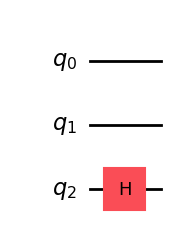

In [157]:
qc.h(2)
qc.draw('mpl')

Next, we want to turn this an extra quarter turn if qubit 1 is in the state $|1\rangle$:

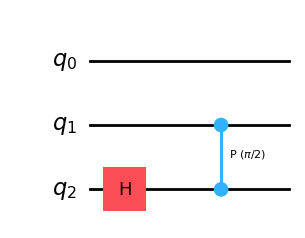

In [158]:
qc.cp(pi/2, 1, 2) # CROT from qubit 1 to qubit 2
qc.draw('mpl')

And another eighth turn if the least significant qubit (0) is $|1\rangle$:

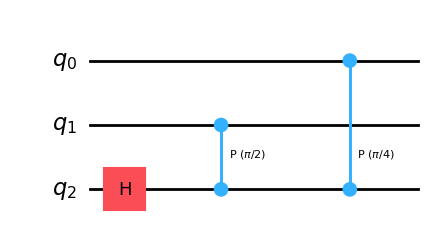

In [159]:
qc.cp(pi/4, 0, 2) # CROT from qubit 2 to qubit 0
qc.draw('mpl')

With that qubit taken care of, we can now ignore it and repeat the process, using the same logic for qubits 0 and 1:

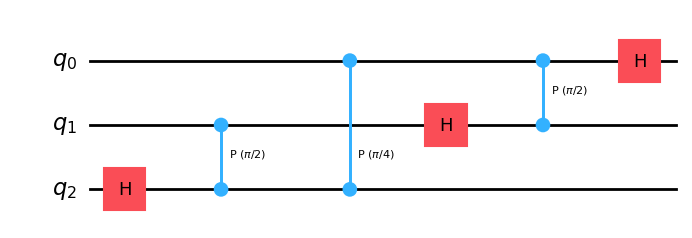

In [160]:
qc.h(1)
qc.cp(pi/2, 0, 1) # CROT from qubit 0 to qubit 1
qc.h(0)
qc.draw('mpl')

Finally we must swap the qubits 0 and 2 to complete the QFT:

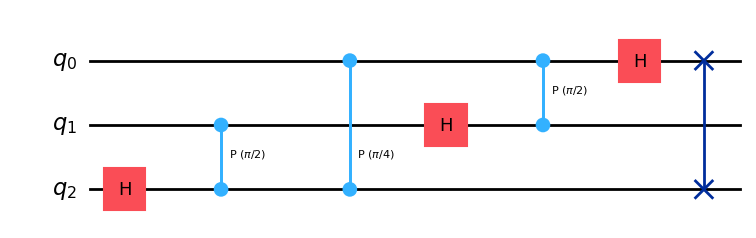

In [161]:
qc.swap(0,2)
qc.draw('mpl')

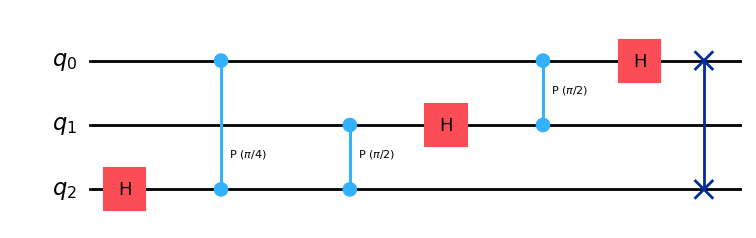

In [162]:
# It might be easier to invert the order of rotations
qc = QuantumCircuit(3)
qc.h(2)
qc.cp(pi/4, 0, 2)
qc.cp(pi/2, 1, 2)

qc.h(1)
qc.cp(pi/2, 0, 1)
qc.h(0)

qc.swap(0,2)
qc.draw('mpl')

# Exercise: 
#Prove that this circuit is equivalent to the one above 
#I Prove it on the board : ) 

### 8.2 General QFT Function <a id="generalqft"></a>

We will now create a general circuit for the QFT in Qiskit. Creating large general circuits like this is really where Qiskit shines. 

It is easier to build a circuit that implements the QFT with the qubits upside down, then swap them afterwards; we will start off by creating the function that rotates our qubits correctly. Let’s start as we did with the 3 qubit example, by correctly rotating the most significant qubit (the qubit with the highest index):

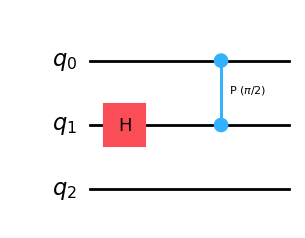

In [163]:
# Define the function qft_rotations(circuit,n) that apply the rotations only on the nth qubit (the most significant one)
#Target behaviour:
circuit = QuantumCircuit(3)
#qft_rotations(circuit, 3)
circuit.h(2)
circuit.cp(pi/4, 0, 2)
circuit.cp(pi/2, 1, 2)
#display(circuit.draw('mpl'))


#Solution:
def qft_rotations(circuit, n):
    pow2=2**n
    circuit.h(n-1)
    for k in range(0,n-1):
        pow2=pow2/2
        circuit.cp(pi/pow2, k, n-1)
    return circuit
circuit = QuantumCircuit(3)
a=(qft_rotations(circuit, 2))
a.draw('mpl')

Let’s see how this looks:

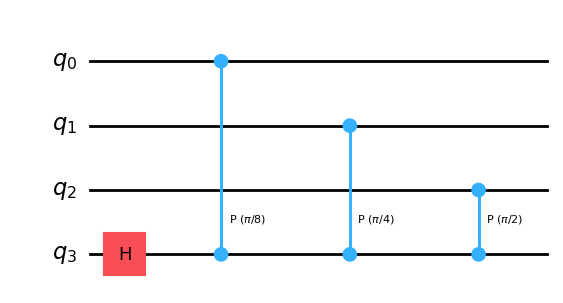

In [164]:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw('mpl')

Great! This is the first part of our QFT. Now we have correctly rotated the most significant qubit, we need to correctly rotate the second most significant qubit. Then we must deal with the third most significant, and so on. But why write more code? When we get to the end of our `qft_rotations()` function, we can use the same code to repeat the process on the next `n-1` qubits:

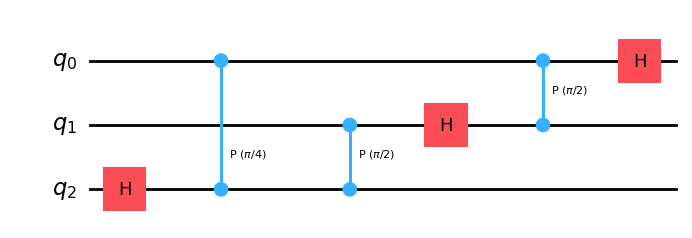

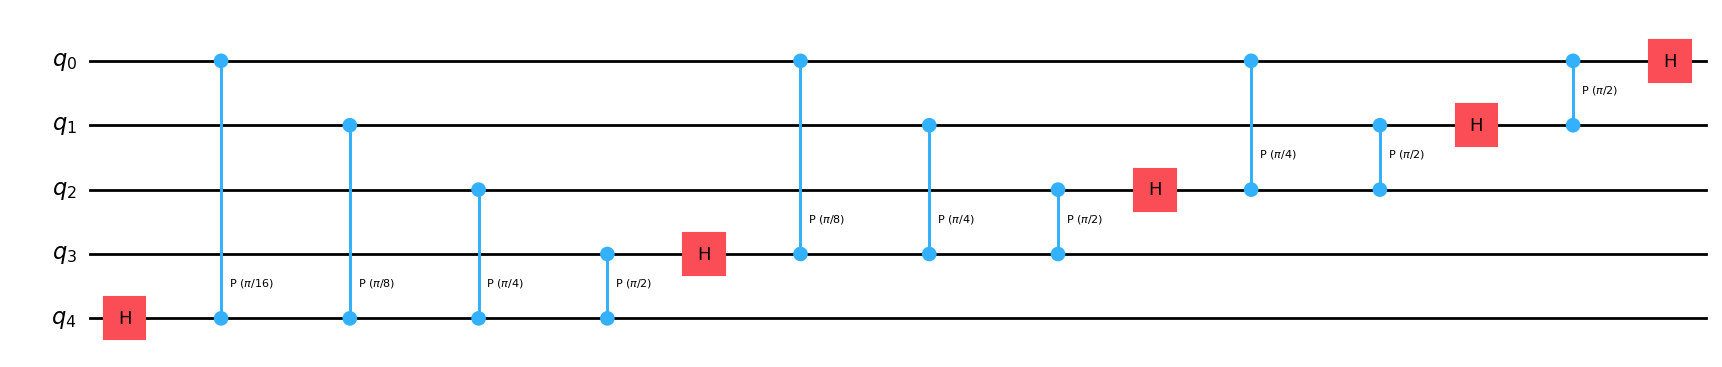

In [165]:
# Exercise: Extend qft_rotations to apply the rotations on all qubits
#Target behaviour:
circuit = QuantumCircuit(3)
#qft_rotations(circuit, 3)
circuit.h(2)
circuit.cp(pi/4, 0, 2)
circuit.cp(pi/2, 1, 2)
circuit.h(1)
circuit.cp(pi/2, 0, 1)
circuit.h(0)
display(circuit.draw('mpl'))


# Solution:
def qft_rotations(circuit, n):
    for i in range(n,-1,-1):
        if i!=0:
            circuit.h(i-1)
        pow2=2**i
        for k in range(0,i-1):
            pow2=pow2/2
            circuit.cp(pi/pow2, k, i-1)
    return circuit


# Let's see how it looks:
qc = QuantumCircuit(5)
qft_rotations(qc,5)
qc.draw('mpl')


Finally, we need to add the swaps at the end of the QFT function to match the definition of the QFT. We will combine this into the final function `qft()`:

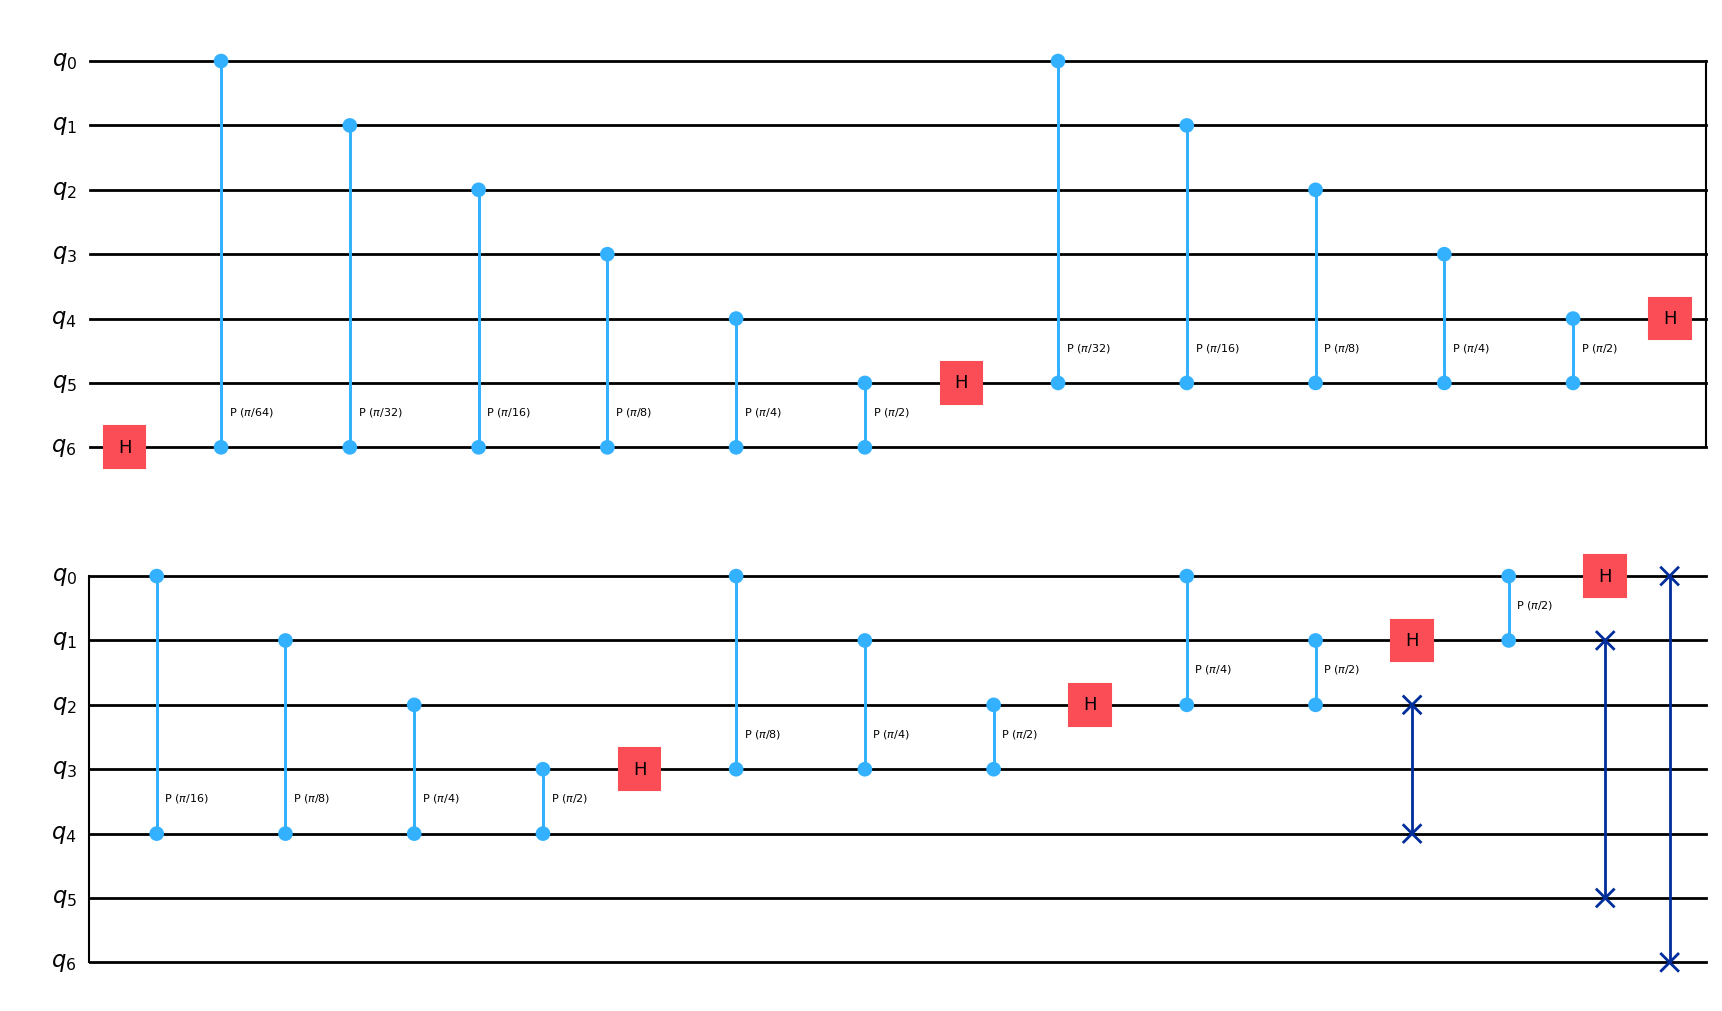

In [187]:
# Write the function to swap the registers at the end of the QFT 
def swap_registers(circuit, n):
    #circuit.barrier()
    for k in range(n):
        i=n-k-1
        if k<i:
            circuit.swap(k,i)
    return circuit


# We can then define the full QFT function
def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(7)
qft(qc,7)
qc.draw('mpl')

We now want to demonstrate this circuit works correctly. To do this we must first encode a number in the computational basis. We can see the number 5 in binary is `101`:

In [188]:
bin(5)

'0b101'

(The `0b` just reminds us this is a binary number). Let's encode this into our qubits:

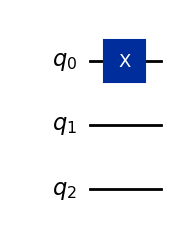

In [215]:
# Create the circuit
qc = QuantumCircuit(3)
zero=[1,0]
un=[0,1]
qc.x(0)
qc.x(2)
qc.draw('mpl')
# Encode the state 5 - remember that all the qubits are initialized in the |0> state


And let's check the qubit's states using the aer simulator:

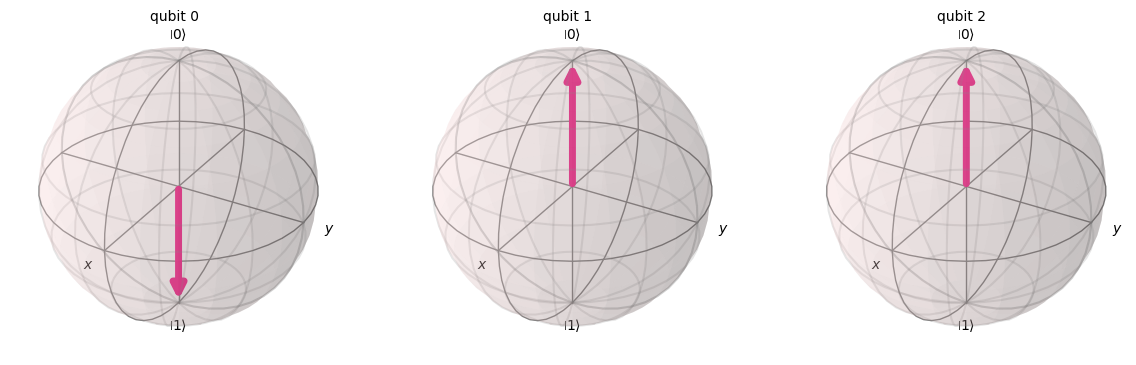

In [216]:
sim = AerSimulator()
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

Finally, let's use our QFT function and view the final state of our qubits:

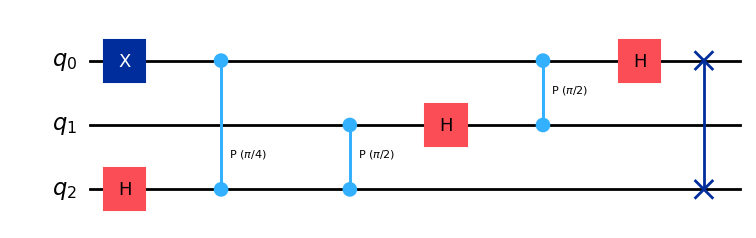

In [217]:
qft(qc,3)
qc.draw('mpl')

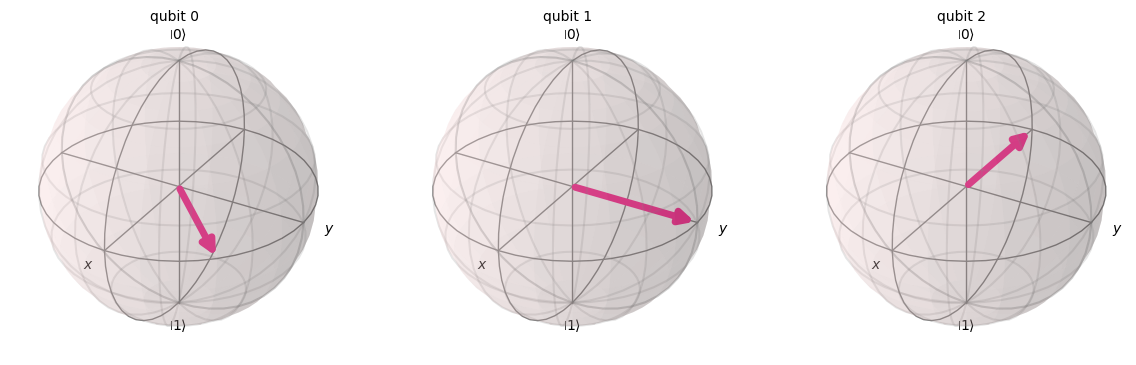

In [218]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

We can see out QFT function has worked correctly. Compared the state $|\widetilde{0}\rangle = |{+}{+}{+}\rangle$, Qubit 0 has been rotated by $\tfrac{5}{8}$ of a full turn, qubit 1 by $\tfrac{10}{8}$ full turns (equivalent to $\tfrac{1}{4}$ of a full turn), and qubit 2 by $\tfrac{20}{8}$ full turns (equivalent to $\tfrac{1}{2}$ of a full turn).

### 8.3 Running QFT on a Real Quantum Device<a id="implementationdev"></a>

If we tried running the circuit at the end of section 8.2 on a real device, the results would be completely random, since all qubits are in equal superposition of $|0\rangle$ and $|1\rangle$. If we want to demonstrate and investigate the QFT working on real hardware, we can instead create the state $|\widetilde{5}\rangle$ seen at the end of section 8.2, run the QFT in reverse, and verify the output is the state $|5\rangle$ as expected. 

Firstly, let’s use Qiskit to easily reverse our QFT operation:

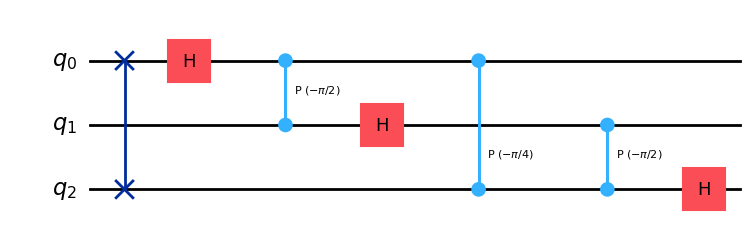

In [203]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse() 
    display(invqft_circ.draw('mpl'))
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose()

# Write the function to swap the registers at the end of the QFT 
def swap_registers2(circuit, n):
    for k in range(n):
        i=n-k-1
        if k<i:
            circuit.swap(k,i)
    return circuit


def qft_rotations2(circuit, n):
    for i in range(0,n+1):
        pow2=2**i
        for k in range(0,i-1):
            pow2=pow2/2
            circuit.cp(-pi/pow2, k, i-1)
        if i!=0:
            circuit.h(i-1)
        #circuit.barrier()

    return circuit

def qft_inverse(circuit, n):
    """QFT on the first n qubits in circuit"""
    swap_registers2(circuit, n)
    qft_rotations2(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(3)
qft_inverse(qc,3)
qc.draw('mpl')
# Exercise:
# Build inverse_qft the same way we built qft (without the inverse() function) - you can use the same rotoations and swap_registers functions 


Now let's put our qubits in the state $|\widetilde{5}\rangle$:

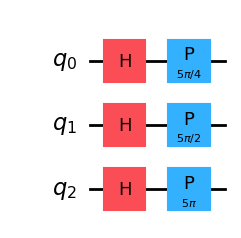

In [204]:
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)

# Exercise: Initialize the state of the qubits to represent the number 5
#qc.x(0)
#qc.x(2)

#solution
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.draw('mpl')

And we can see this does indeed result in the Fourier state $|\widetilde{5}\rangle$:

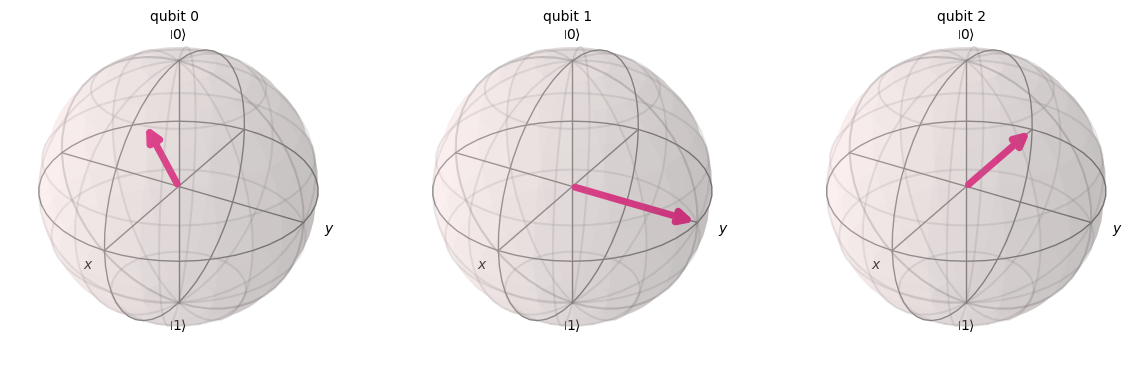

In [195]:
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

Finally, let's apply our inverse QFT:

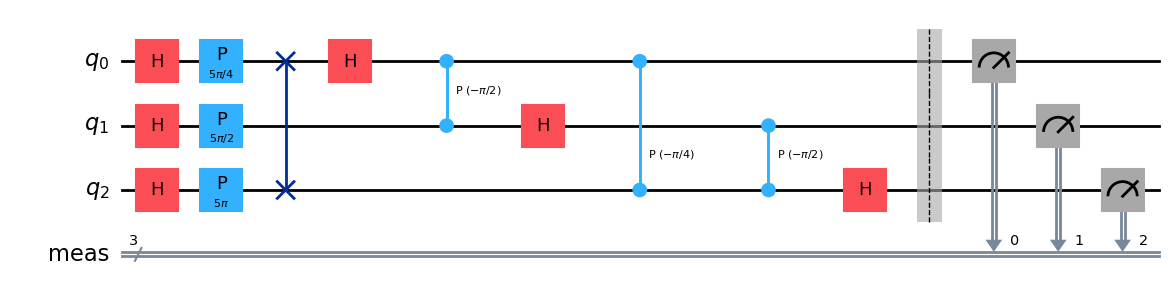

In [205]:
qc = qft_inverse(qc, nqubits)
qc.measure_all()
qc.draw('mpl')

In [206]:
simulator = AerSimulator()
simulator.run(qc)

#qc.save_statevector()
#statevector = sim.run(qc).result().get_statevector()
#plot_bloch_multivector(statevector)

# Run it on real hardware

In [207]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy()
print(backend.name)
sampler = Sampler(mode=backend)
sampler.options.default_shots = 100

ibm_sherbrooke


In [208]:
# transpiling the circuits
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
qc_transpiled = pm.run(qc)

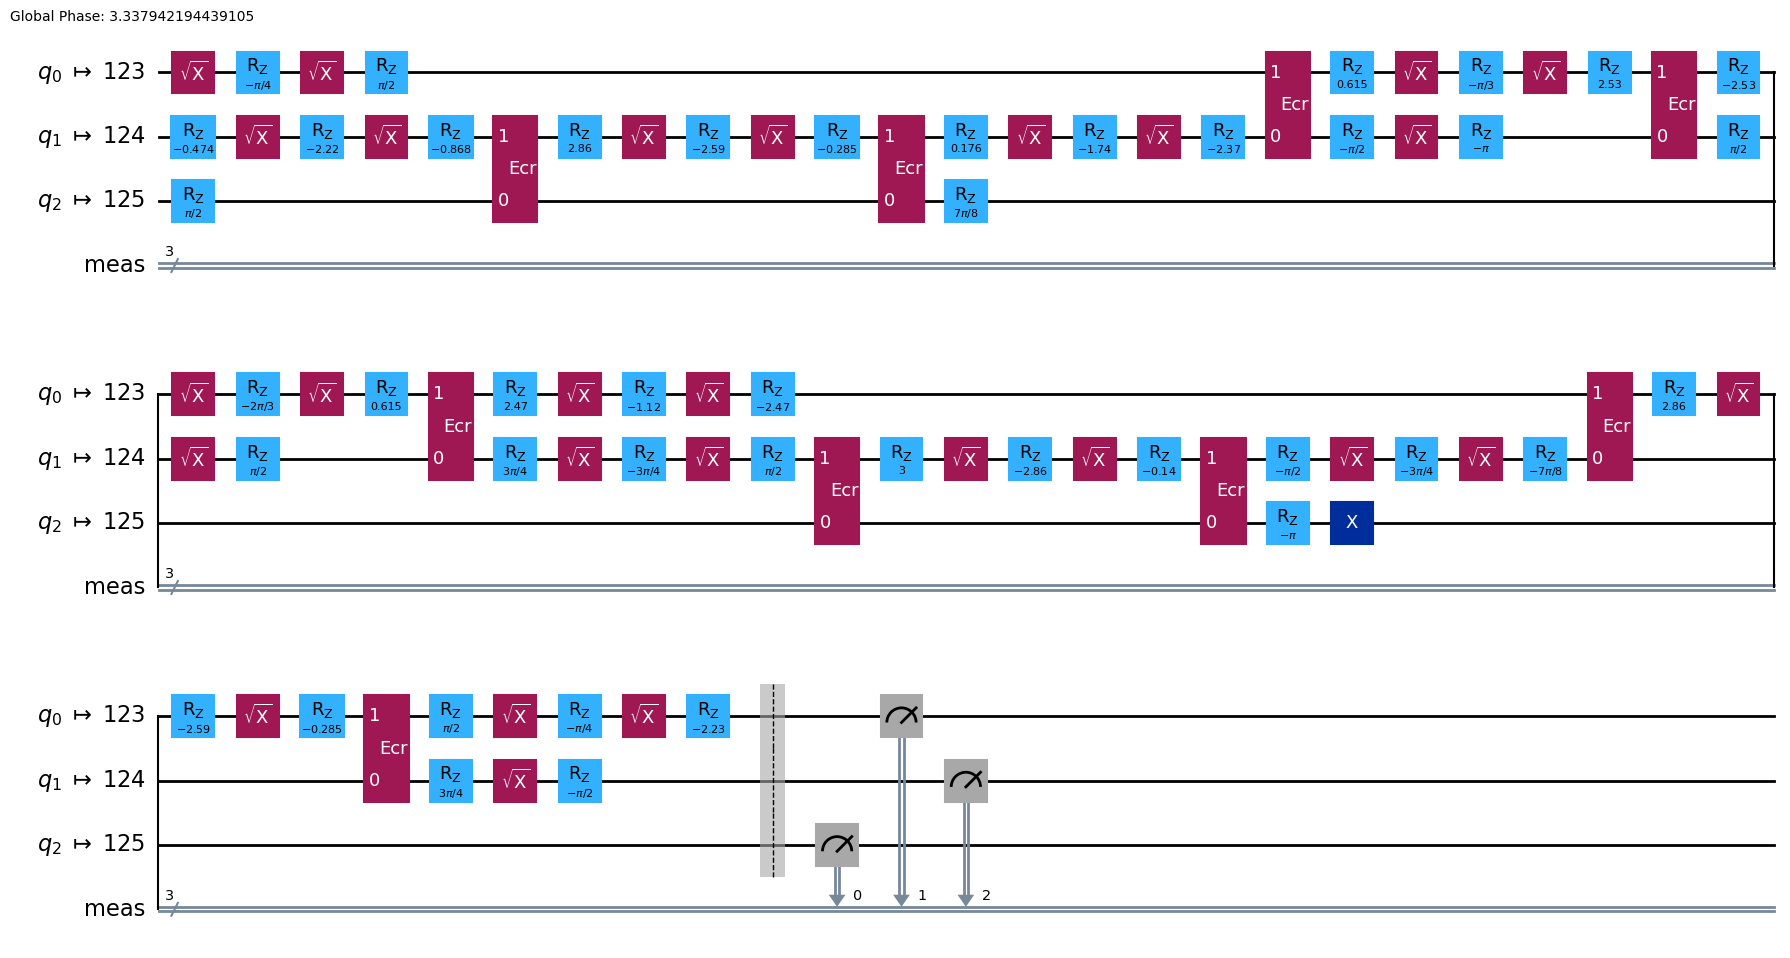

In [209]:
qc_transpiled.draw('mpl', idle_wires=False)

In [210]:
shots = 1_000
job = sampler.run([qc_transpiled], shots=shots)


In [211]:
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cz4r3rq1xvhg008e89t0
>>> Job Status: QUEUED


In [212]:
job.result()[0].data

DataBin(meas=BitArray(<shape=(), num_shots=1000, num_bits=3>))

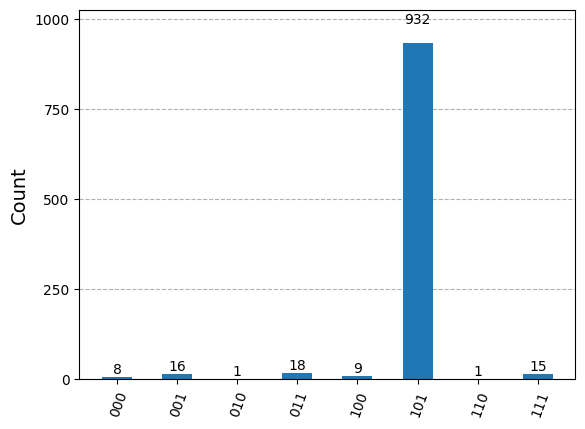

In [214]:
counts = job.result()[0].data.meas.get_counts()
plot_histogram(counts)

We (hopefully) see that the highest probability outcome is $101$.

## 9. Problems<a id="problems"></a>

1. The [above implementation](#implementationdev) of QFT was tested by preparing the Fourier state $|\widetilde{5}\rangle$ for which $\text{QFT}^{\dagger}|\widetilde{5}\rangle = |101\rangle$. Try to find the state $|a\rangle$ such that $\text{QFT}^{\dagger}|a\rangle = |100\rangle$.
2. Find the state $|b\rangle$ such that $\text{QFT}^{\dagger}|b\rangle = |011\rangle$.
3. Try to write the QFT function without recursion. Use Qiskit's unitary simulator to verify your results.

In [ ]:
we obtain |a> =QFT(|100>)

## 10. References<a id="references"></a>

1. M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).